Solar Energy Potential	ene.015	http://www.vaisala.com/en/energy/Documents/WEA-ERG-3TIER-Global%20Solar%20Validation.pdf

Import libraries

In [3]:
# Libraries for downloading data from remote server (may be ftp)
import requests
from urllib.request import urlopen
from contextlib import closing
import shutil

# Library for uploading/downloading data to/from S3
import boto3

# Libraries for handling data
import rasterio as rio
import numpy as np
# from netCDF4 import Dataset
# import pandas as pd
# import scipy

# Libraries for various helper functions
# from datetime import datetime
import os
import threading
import sys
from glob import glob
from matplotlib import pyplot
%matplotlib inline

s3 tools

In [4]:
s3_upload = boto3.client("s3")
s3_download = boto3.resource("s3")

s3_bucket = "wri-public-data"
s3_folder = "resourcewatch/raster/ene_015_solar_energy_potential/"

s3_file = "ene_015_solar_energy_potential.tif"

s3_key_orig = s3_folder + s3_file
s3_key_edit = s3_key_orig[0:-4] + "_edit.tif"

os.environ["Zs3_key1"] = "s3://wri-public-data/" + s3_key_orig
os.environ["Zs3_key2"] = "s3://wri-public-data/" + s3_key_edit

class ProgressPercentage(object):
        def __init__(self, filename):
            self._filename = filename
            self._size = float(os.path.getsize(filename))
            self._seen_so_far = 0
            self._lock = threading.Lock()

        def __call__(self, bytes_amount):
            # To simplify we'll assume this is hooked up
            # to a single filename.
            with self._lock:
                self._seen_so_far += bytes_amount
                percentage = (self._seen_so_far / self._size) * 100
                sys.stdout.write("\r%s  %s / %s  (%.2f%%)"%(
                        self._filename, self._seen_so_far, self._size,
                        percentage))
                sys.stdout.flush()

Define local file locations

In [5]:
local_folder = "C:/Users/Max81007/Desktop/Python/Resource_Watch/Raster/ene.015/"
file_name = "ene_015_solar_energy_potential.tif"

local_orig = local_folder + file_name

orig_extension_length = 4 #4 for each char in .tif
local_edit = local_orig[:-orig_extension_length] + "_edit.tif" 

In [4]:
files = [local_orig, local_edit]
for file in files:
    with rio.open(file, 'r') as src:
        profile = src.profile
        print(profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 10800, 'height': 3450, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.03333333333333333, 0.0, -180.0,
       0.0, -0.03333333333333333, 60.0), 'tiled': False, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 10800, 'height': 3450, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.03333333333333333, 0.0, -180.0,
       0.0, -0.05217391304347826, 90.0), 'compress': 'lzw', 'tiled': False, 'interleave': 'band'}


Use rasterio to reproject and compress

In [5]:
os.getcwd()
os.chdir(local_folder)
os.environ["local_orig"] =local_orig
os.environ["local_edit"] =local_edit

In [8]:
!gdalwarp -overwrite -t_srs epsg:4326 -srcnodata none -co compress=lzw -wo SOURCE_EXTRA=1000 %local_orig% %local_edit%

0...10...20...30...40...50...60...70...80...90...100 - done.


In [9]:
files = [local_orig, local_edit]
for file in files:
    with rio.open(file, 'r') as src:
        profile = src.profile
        print(profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 10800, 'height': 3450, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.03333333333333333, 0.0, -180.0,
       0.0, -0.03333333333333333, 60.0), 'tiled': False, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10800, 'height': 3450, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.03333333333333333, 0.0, -180.0,
       0.0, -0.03333333333333333, 59.99999999999999), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


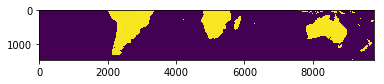

In [11]:
with rio.open(local_orig) as src:
    window = ((2000,3450), (1000,10800)) 
    data = src.read(indexes=1, window=window)
    pyplot.imshow(data)

In [7]:
print(local_orig)

C:/Users/Max81007/Desktop/Python/Resource_Watch/Raster/ene.015/ene_015_solar_energy_potential.tif


Upload orig and edit files to s3

In [10]:
# Original
s3_upload.upload_file(local_orig, s3_bucket, s3_key_orig,
                         Callback=ProgressPercentage(local_orig))

# Edit
s3_upload.upload_file(local_edit, s3_bucket, s3_key_edit,
                         Callback=ProgressPercentage(local_edit))

C:/Users/Max81007/Desktop/Python/Resource_Watch/Raster/ene.015/ene_015_solar_energy_potential_edit.tif  108889033 / 108889033.0  (100.00%)

In [14]:
os.environ["Zgs_key"] = "gs://resource-watch-public/" + s3_key_orig

In [15]:
!echo %Zs3_key2%
!echo %Zgs_key%

s3://wri-public-data/resourcewatch/raster/ene_015_solar_energy_potential/ene_015_solar_energy_potential_edit.tif
gs://resource-watch-public/resourcewatch/raster/ene_015_solar_energy_potential/ene_015_solar_energy_potential.tif


In [16]:
!gsutil cp %Zs3_key2% %Zgs_key%

Non-MD5 etag ("78390f3985e07a4b7375998b7242bc70-13") present for key <Key: wri-public-data,resourcewatch/raster/ene_015_solar_energy_potential/ene_015_solar_energy_potential_edit.tif>, data integrity checks are not possible.
Copying s3://wri-public-data/resourcewatch/raster/ene_015_solar_energy_potential/ene_015_solar_energy_potential_edit.tif [Content-Type=binary/octet-stream]...
/ [0 files][    0.0 B/103.8 MiB]                                                
-
- [0 files][  2.1 MiB/103.8 MiB]                                                
\
|
| [0 files][  5.2 MiB/103.8 MiB]                                                
/
/ [0 files][  8.0 MiB/103.8 MiB]                                                
-
\
\ [0 files][ 11.6 MiB/103.8 MiB]                                                
|
/
/ [0 files][ 15.7 MiB/103.8 MiB]                                                
-
- [0 files][ 19.1 MiB/103.8 MiB]                                                
\
|
| [0 files][ 23.0 MiB/103.8

In [21]:
os.environ["asset_id"] = "users/resourcewatch/ene_015_solar_energy_potential"
!earthengine upload image --asset_id=%asset_id% %Zgs_key%

Started upload task with ID: D3ZEILLSAD73D3AQIIQTDILW
